In [1]:
import os
from typing import Optional, Literal
import openai

# Important! Uncomment this line to set your own API key
# os.environ["OPEN_AI_KEY"] = "sk-..."

from utils import *

# 1. Python in 10 minutes

This interface allows you to run Python code interactively and view the results immediately, along with any visualizations or text explanations. Each block of code or text you see is contained in what we call a "cell."

## Basic Operations

- **Running a Cell**: You can run the code or render the markdown in a cell by selecting it and pressing `Shift + Enter`, or by clicking the "Run" button in the toolbar.
- **Adding New Cells**: Add a new cell by clicking the "+" button in the toolbar.
- **Cell Types**: Cells can be code cells or markdown cells. Switch the type using the dropdown in the toolbar.


In [2]:
# Simple Python Example

# Printing a message
print("Hello, World!")

# Basic arithmetic
result = 7 * 6
print("7 multiplied by 6 is", result)

Hello, World!
7 multiplied by 6 is 42


In [3]:
# Using Variables

# Store a value in a variable
a = 10

# Use the variable in a calculation
b = a * 2

# Print the result
print("The result of a multiplied by 2 is", b)

The result of a multiplied by 2 is 20


In [4]:
# Basic Data Structures

# List: an ordered collection of items
fruits = ["apple", "banana", "cherry"]
print("Fruits List:", fruits)

# Dictionary: key-value pairs
prices = {"apple": 0.40, "banana": 0.50, "cherry": 0.30}
print("Fruit Prices:", prices)

Fruits List: ['apple', 'banana', 'cherry']
Fruit Prices: {'apple': 0.4, 'banana': 0.5, 'cherry': 0.3}


In [5]:
# Looping through a list
for fruit in fruits:
    print(fruit, "costs", prices[fruit], "each")

# Conditional: if statement
if "banana" in fruits:
    print("Yes, we have bananas!")

apple costs 0.4 each
banana costs 0.5 each
cherry costs 0.3 each
Yes, we have bananas!


### Introduction to Functions

Functions are a way to organize your code into blocks that can be called multiple times throughout your program. They allow you to write cleaner, more modular code and make your scripts easier to maintain and debug. Functions in Python are defined using the `def` keyword.


In [6]:
# Defining a Simple Function


def greet(name):
    """This function greets the person whose name is passed as a parameter"""
    return f"Hello, {name}! Welcome to our notebook."


# Calling the function
greeting = greet("Alice")
print(greeting)

Hello, Alice! Welcome to our notebook.


In [7]:
# Function with Parameters and Return Value


def calculate_area(length, width):
    """This function returns the area of a rectangle given its length and width."""
    area = length * width
    return area


# Using the function
rect_area = calculate_area(10, 5)
print("The area of the rectangle is:", rect_area)

The area of the rectangle is: 50


### Creating Prompts 

In [8]:
# you can add a variable to a string by using format

name = "Lebron James"

template = """{name} is from Ohio"""

print("Without calling format:", template)
print("After calling format:", template.format(name=name))

Without calling format: {name} is from Ohio
After calling format: Lebron James is from Ohio


### Let's get started with the case study!


# High Level Architecture

The architecture of the system is as follows:

1. We chunk up the document into distinct “sections” and embed those sections
2. Then, we embed the user query and find the most similar part of the document.
3. We feed the original question along with context we found to the LLM and receive an answer


# 2. What exactly is an embedding?


In [9]:
from openai import OpenAI, NOT_GIVEN
import plotly.graph_objects as go

#########################
### UTILITY FUNCTIONS ###
#########################

# instantiating the OpenAI client
client = OpenAI(api_key=os.getenv("OPEN_AI_KEY"))
batch_size = 250
embedding_model = "text-embedding-3-small"


# wrapper function around openai to directly return embedding of text
def get_embedding(text: str | list[str], dimensions: int = NOT_GIVEN) -> list[float]:
    """Get the embedding of the input text."""
    if dimensions:
        assert dimensions <= 256, "The maximum number of dimensions is 256."

    response = client.embeddings.create(
        input=text, model=embedding_model, dimensions=dimensions
    )
    return response.data[0].embedding


def get_many_embeddings(texts: list[str]) -> list[list[float]]:
    """Get the embeddings of multiple texts."""
    batch_size = 250
    res = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        api_resp = client.embeddings.create(input=batch_texts, model=embedding_model)
        batch_res = [val.embedding for val in api_resp.data]
        res.extend(batch_res)

    return res


# simple utility function to add a vector to a 3D plot
def add_vector_to_graph(
    fig: go.Figure, vector: list[float], color: str = "red", name: Optional[str] = None
) -> go.Figure:
    # Ensure vector has exactly three components
    assert len(vector) == 3, "Vector must have exactly 3 components to visualize."

    # Origin point
    origin = [0, 0, 0]

    # Components of the vector
    x_component, y_component, z_component = vector

    # Adding the line part of the vector
    fig.add_trace(
        go.Scatter3d(
            x=[origin[0], x_component],
            y=[origin[1], y_component],
            z=[origin[2], z_component],
            mode="lines",
            line=dict(color=color, width=5),
            name=name,
        )
    )

    # Adding the cone at the tip of the vector
    fig.add_trace(
        go.Cone(
            x=[x_component],
            y=[y_component],
            z=[z_component],
            u=[x_component],
            v=[y_component],
            w=[z_component],
            sizemode="scaled",
            sizeref=0.1,
            showscale=False,
            colorscale=[[0, color], [1, color]],
            hoverinfo="none",
        )
    )
    return fig


def create_new_graph() -> go.Figure:
    """Create a 3D plotly figure with a simple layout."""
    fig = go.Figure()

    # make sure the plot isn't rotated
    fig.update_layout(
        scene=dict(
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=0.5),  # Adjust the camera position
                up=dict(x=0, y=0, z=1),  # Sets the z-axis as "up"
                center=dict(x=0, y=0, z=0),  # Focuses the camera on the origin
            ),
            aspectmode="cube",
        )
    )

    # Add a dot at the origin
    fig.add_trace(
        go.Scatter3d(
            x=[0],
            y=[0],
            z=[0],
            mode="markers",
            marker=dict(size=6, color="black", symbol="circle"),
            name="Origin",
        )
    )

    return fig

#### Let's get started

For the purpose of the notebook we're going to use an OpenAI approach.

In [10]:
# let's try using the get_embedding function
result = get_embedding("lead contamination")
print(result)

[0.0016663320129737258, -0.02062450535595417, 0.039352159947156906, 0.0316443145275116, -0.027173161506652832, -0.005370651371777058, 0.012239214032888412, -0.013232802972197533, -0.0534430593252182, -0.006642746739089489, 0.054828062653541565, -0.014000576920807362, 0.006100788712501526, -0.015460851602256298, -0.009371353313326836, 0.008949831128120422, 0.032457251101732254, -0.030153930187225342, -0.07195995002985, 0.005931427236646414, 0.02097075618803501, 0.04073715955018997, 0.03607030212879181, 0.026706475764513016, -0.018456673249602318, -0.03230670839548111, 0.017463084310293198, -0.021046027541160583, -0.005795937497168779, 0.0005010286695323884, 0.017086725682020187, -0.03601008653640747, -0.016589930281043053, -0.022656846791505814, -0.003116257255896926, -0.015701722353696823, 0.06497471779584885, -0.006729309447109699, -0.0373348705470562, -0.026435496285557747, -0.02760973945260048, 0.026811856776475906, 0.019962111487984657, 0.021738529205322266, 0.006665328051894903, 0

That's a lot of numbers! OpenAI embedding support built in dimensionality reduction - let's try using that and visualizing the result


In [11]:
graph = create_new_graph()

text = "lead contamination"

# Get the embedding of the text
vector = get_embedding(text, dimensions=3)
print(f"Resulting vector: {vector} with {len(vector)} dimensions")

# Add the vector to the plot
add_vector_to_graph(graph, vector, name=text)

# Show the plot
graph.show()

Resulting vector: [0.03761640936136246, -0.4646907448768616, 0.8846736550331116] with 3 dimensions


Let's try plotting a couple vectors at once to see if we can see any patterns

In [12]:
graph = create_new_graph()

text = "lead contamination"
lead_contamination_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, lead_contamination_vector, name=text, color="purple")

text = "asbestos"
asbestos_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, asbestos_vector, name=text, color="blue")

text = "judo"
judo_vector = get_embedding(text, dimensions=3)
add_vector_to_graph(graph, judo_vector, name=text, color="red")

# Show the plot
graph.show()

How we can quantify the similarity between two vectors? One common way is to use the cosine similarity. The cosine similarity between two vectors is the cosine of the angle between them. It ranges from -1 (opposite directions) to 1 (same direction), with 0 indicating orthogonality.

*Note:* You can try your own vectors by changing the text variable in the code above. You may see unintuitive results because we're only using 3 dimensions - increasing the dimensions will help (although we won't be able to visualize it).


In [13]:
import numpy as np


def cosine_similarity(a: list[float], b: list[float]) -> float:
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


# We can use the cosine similarity to compare the similarity between two vectors
similarity = cosine_similarity(lead_contamination_vector, judo_vector)
print(f"The similarity between 'lead contamination' and 'judo' is {similarity:.2f}")

similarity = cosine_similarity(lead_contamination_vector, asbestos_vector)
print(f"The similarity between 'lead contamination' and 'asbestos' is {similarity:.2f}")

The similarity between 'lead contamination' and 'judo' is -0.65
The similarity between 'lead contamination' and 'asbestos' is 0.96


# 3. Parsing Documents

Large language models are currently primarly optimized for working with text. As a result when dealing with documents like PDF's we need to first convert them into a text format before we can feed them into the model.

We maintain a popular open source library for doing this called [openparse](https://github.com/Filimoa/open-parse/). It is a simple and easy to use.


In [14]:
import openparse

#########################
### UTILITY FUNCTIONS ###
#########################


class VectorDatabase:
    """
    A simple in-memory database to store nodes along with their vectors and perform similarity search.
    """

    def __init__(self):
        self.nodes = []

    def add_node(self, node: openparse.Node) -> None:
        """Add a node along with its vector to the database."""
        assert node.embedding is not None, "Node must have an embedding."

        for existing_node in self.nodes:
            if existing_node.text == node.text:
                print(f"Node with id {node.node_id} already exists. Skipping")
                return

        self.nodes.append(node)

    def find_node(self, node_id: str):
        """Retrieve a node by its ID."""
        for node in self.nodes:
            if node.node_id == node_id:
                return node
        return None

    def find_similar_node(
        self, input_vector: list[float], top_k: int = 3
    ) -> list[openparse.Node]:
        """Find the top_k nodes with the highest cosine similarity to the input_vector."""
        assert self.nodes, "Database is empty. Please add nodes first."
        assert top_k <= len(self.nodes), (
            "top_k should be less than or equal to the number of nodes."
        )

        similarities = []
        for node in self.nodes:
            similarity = cosine_similarity(input_vector, node.embedding)
            similarities.append((node, similarity))

        similarities.sort(key=lambda x: x[1], reverse=True)

        return [node for node, _ in similarities[:top_k]]

    @property
    def num_nodes(self) -> int:
        """Return the number of nodes in the database."""
        return len(self.nodes)

    def delete_all_nodes(self) -> None:
        """Delete all nodes from the database."""
        self.nodes = []


db = VectorDatabase()

In [15]:
import openparse

doc_path = "./docs/portland-site-assessment-phase-1.pdf"
pdf = openparse.Pdf(doc_path)
parser = openparse.DocumentParser()
parsed_doc = parser.parse(doc_path)

Let's try looking at the first couple nodes.

In [16]:
for node in parsed_doc.nodes[10:11]:
    display(node)
    print("====================================")

RECOGNIZED ENVIRONMENTAL CONDITIONS <br><br>ASTM E1527-13 defines RECs as the presence or likely presence of any hazardous substances or 
petroleum products in, on, or at a property: (1) due to any release to the environment; (2) under 
conditions indicative of a release to the environment; or (3) under conditions that pose a material 
threat of a future release to the environment. <br><br>No uncontrolled RECs were identified for the Property. <br><br>CONTROLLED RECOGNIZED ENVIRONMENTAL CONDITIONS <br><br>ASTM E1527-13 defines controlled RECs (CRECs) as resulting from a past release of hazardous 
substances or petroleum products that has been addressed to the satisfaction of the applicable 
regulatory authority. <br><br>The CRECs identified through completion of this Phase I ESA are noted below and are discussed in 
further detail throughout this report. Figure ES-1 displays the area names used to describe different 
portions of the Property. <br><br>• Groundwater concentration in excess of the DEQ residential, urban residential, and 
occupational risk-based concentrations (RBCs) for lead, arsenic, polycyclic aromatic 
hydrocarbons (PAHs), diesel-range organics (DRO), and residual-range organics (RRO) 
have been observed on portions of the Property. In addition, benzo(a)pyrene (a PAH) 
was observed in groundwater in excess of the DEQ excavation worker RBC in two 
locations on the southeastern portion of the Property (one in Riverside and one in the 
Barker Area). <br><br>• PAHs in shallow soil above the DEQ residential, urban residential, and occupational <br><br>RBCs in the Lumber Mill Area. 

Now let's embed all the nodes and add to the database.

<img src="https://sergey-filimonov.nyc3.cdn.digitaloceanspaces.com/misc/misc-data-or-images-for-notebooks/parsing-v2.png" alt="Parsing Overview" style="width: 80%; height: auto; display: block; margin-left: auto; margin-right: auto;">

In [17]:
# let's embed all the nodes and add to the database
raw_node_texts = [node.text for node in parsed_doc.nodes]
embeddings = get_many_embeddings(raw_node_texts)

for node, embedding in zip(parsed_doc.nodes, embeddings):
    node.embedding = embedding
    db.add_node(node)

print("=== Database now has ", db.num_nodes, " nodes ===")

Node with id 71bcc62f-ca25-4026-a09f-661472113b06 already exists. Skipping
=== Database now has  77  nodes ===


# 4. Querying

In [18]:
#########################
### UTILITY FUNCTIONS ###
#########################

from IPython.display import Markdown


def get_completion(prompt: str) -> Markdown:
    """
    OpenAI returns a complex object, this is a simple wrapper function to directly return the completion text.
    """
    completion = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
    )

    cost_per_million_tokens = 4.00
    cost_dollars = completion.usage.total_tokens / 1_000_000 * cost_per_million_tokens

    print(
        f"Completion used {completion.usage.total_tokens} tokens costing ${cost_dollars:.2f}"
    )

    return Markdown(completion.choices[0].message.content)


def display_similar_nodes(
    similar_nodes: list[openparse.Node], query_vector: list[float], pdf: openparse.Pdf
) -> None:
    page_nums = set()
    annotations = []
    for node in similar_nodes:
        sim = cosine_similarity(query_vector, node.embedding)
        page_nums.add(node.start_page)
        page_nums.add(node.end_page)
        annotations.append(round(sim, 3))

    pdf.display_with_bboxes(similar_nodes, page_nums=page_nums, annotations=annotations)

In [19]:
# let's try asking one of our original questions

question = "Is there lead contamination into the groundwater?"

# Get the embedding of the text
query_vector = get_embedding(question)

# find the most similar node
similar_nodes = db.find_similar_node(query_vector, top_k=5)

for node in similar_nodes:
    sim = cosine_similarity(query_vector, node.embedding)
    print(
        f"Found similar node on page {node.start_page} with a similarity of {sim:.2f}"
    )

Found similar node on page 24 with a similarity of 0.55
Found similar node on page 26 with a similarity of 0.54
Found similar node on page 31 with a similarity of 0.54
Found similar node on page 28 with a similarity of 0.53
Found similar node on page 28 with a similarity of 0.52


In [20]:
# create a single string of all the similar nodes
context = "\n\n".join([node.text for node in similar_nodes])

print(context)

Lead-impacted soil along a portion of the northwestern periphery of the Property was also observed 
in samples collected from test pits. Approximately 1,708 tons of impacted soil was excavated from 
this area and disposed of off site. The target cleanup levels used during this removal action were 400 
parts per million (ppm) for soil up to 3 feet bgs and 800 ppm for soil at depths greater than 3 feet. A 
description of the confirmation samples and sample results includes a thin layer of residual soil on 
bedrock in the deepest part of the excavation (approximately 5-10 feet bgs), with concentrations 
remaining above target cleanup levels. Additionally, residual lead levels above RBCs for both 
residential and construction/excavation workers are present in samples along the northern sidewall 
of the excavation within about 3 feet of the property boundary. Impacted soil near the property 
boundary could not be removed due to concerns about damaging the adjacent building to the north, 
or

### Ok let's try running a completion

To reiterate, we first query the document for the most relevant information using the vector search. Then we feed the question and the context into the LLM to get an answer.

<img src="https://sergey-filimonov.nyc3.cdn.digitaloceanspaces.com/misc/misc-data-or-images-for-notebooks/eca-docs-rag-overview-v2.png">

In [21]:
prompt_template = """
Using the document provided, answer the following question:

question: {question}

context: {context}
"""

prompt = prompt_template.format(question=question, context=context)

completion = get_completion(prompt)

print("Original Question:", question)
completion

Completion used 1419 tokens costing $0.01
Original Question: Is there lead contamination into the groundwater?


Yes, there is lead contamination in the groundwater. The document mentions that lead residential, urban residential, and occupational Risk-Based Concentrations (RBCs) exceedances were observed in groundwater in three out of four locations assessed in the Lathe Area. Another assessment for lead in groundwater was done in the Riverside area, where lead was not detected above RBCs in those samples.

### We can display citations showing users exactly where we got our answer

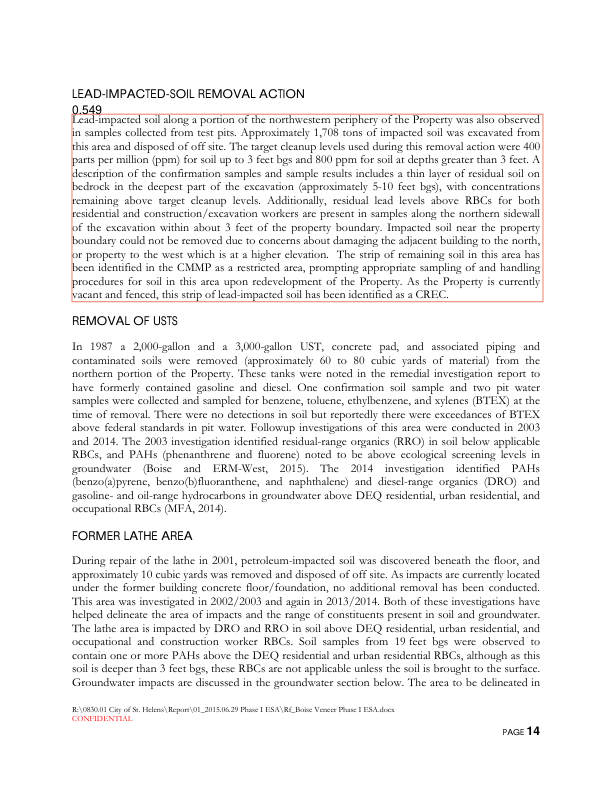

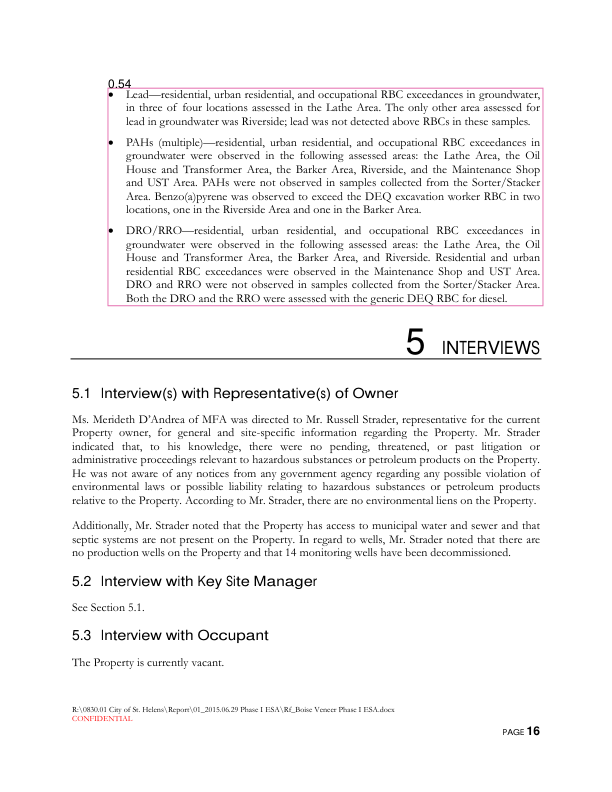

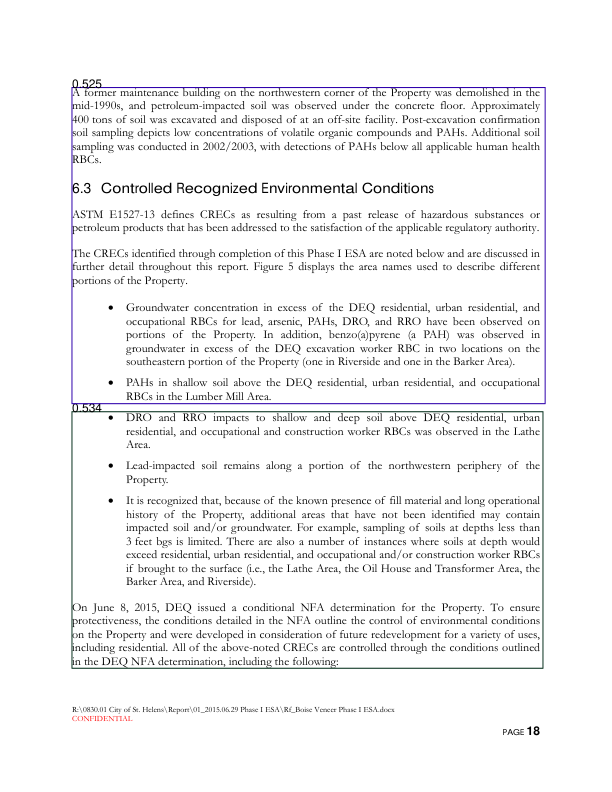

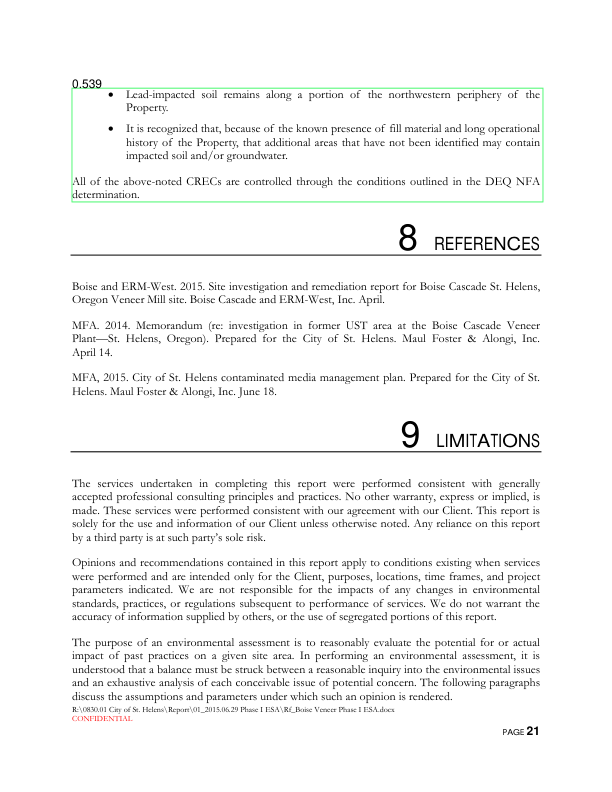

In [22]:
display_similar_nodes(similar_nodes, query_vector, pdf)

## 5: Structured Output

In [23]:
from pydantic import BaseModel


class ContainsHazards(BaseModel):
    has_lead: bool


response = client.beta.chat.completions.parse(
    model="gpt-4o",
    messages=[
        {
            "role": "user",
            "content": prompt,
        },
    ],
    response_format=ContainsHazards,
)

response = response.choices[0].message.parsed
print(response)

has_lead=True


### Conditional Prompting

We can use the output of the model to drill into a more specific question. So in our case we found there was lead contamination, so we can ask a more specific question about the mitigations performed.

<img src="https://sergey-filimonov.nyc3.cdn.digitaloceanspaces.com/misc/misc-data-or-images-for-notebooks/structured-outputs-overview-v2.png" alt="Structured Outputs Overview">

In [24]:
if response.has_lead:
    question = "What mitigations have been performed up to this point to deal with the lead exposure?"

    query_vector = get_embedding(question)

    similar_nodes = db.find_similar_node(query_vector, top_k=5)

    context = "\n\n".join([node.text for node in similar_nodes])

    prompt = prompt_template.format(question=question, context=context)

    mitigations_performed = get_completion(prompt)

Completion used 1984 tokens costing $0.01


In [25]:
mitigations_performed

To address the issue of lead exposure, the following mitigations have been implemented:

1. **Excavation and Disposal**: Approximately 1,708 tons of lead-impacted soil were excavated from the northwestern periphery of the property and disposed of offsite. The excavation aimed to meet target cleanup levels of 400 parts per million (ppm) for soil up to 3 feet below ground surface (bgs) and 800 ppm for deeper soil.

2. **Management of Residual Soil**: A thin layer of residual soil with lead concentrations above target cleanup levels remains on bedrock in the deepest part of the excavation. This area has been identified as a Controlled Recognized Environmental Condition (CREC) with restricted access, requiring proper handling and sampling during future property redevelopment.

3. **Implementation of a Conditional No Further Action (NFA) Determination**: On June 8, 2015, the Department of Environmental Quality (DEQ) issued a conditional NFA determination. This entails control of environmental conditions on the property, addressing CRECs through certain outlined conditions to ensure future protectiveness.

Additionally, other mitigation activities regarding the broader site contamination, not specifically limited to lead but relevant to overall environmental management, included:

- Demolition of a former maintenance building and excavation of approximately 400 tons of petroleum-impacted soil, with post-excavation sampling showing low concentrations of pollutants.
- Controlled Recognized Environmental Conditions (CRECs) were established for areas where past releases were satisfactorily addressed by regulatory authorities, including conditions in the DEQ's NFA determination for future control.

The combination of these measures aims to manage existing contamination and set guidelines for handling any residual impact during potential future property uses.

In [26]:
question = (
    "Why were the following mitigations to remove the lead from the property ineffective "
    + mitigations_performed.data
)

query_vector = get_embedding(question)

# this is a more complex question, let's expand the search to top 9 nodes
similar_nodes = db.find_similar_node(query_vector, top_k=9)

context = "\n\n".join([node.text for node in similar_nodes])

prompt = prompt_template.format(question=question, context=context)

failure_reasons = get_completion(prompt)

Completion used 3352 tokens costing $0.01


In [27]:
failure_reasons

The mitigations to remove lead from the property were ineffective for several reasons:

1. **Incomplete Excavation**: Even though a significant quantity of lead-impacted soil was excavated, a thin layer of residual soil with lead concentrations above the target cleanup levels remained on the bedrock at the deepest part of the excavation. These areas were identified as Controlled Recognized Environmental Conditions (CRECs) but were not fully remediated, meaning there was no complete removal, leaving lead contamination still present and posing a risk.

2. **Access Constraints**: There were physical limitations during the soil removal process. Specifically, certain areas near the property boundary could not be excavated due to concerns about damaging adjacent structures, which meant that some contaminated soils were left in situ.

3. **Presence of Fill Material and Historical Use**: The property's long operational history and known presence of fill material indicate that additional unidentified areas might contain impacted soil or groundwater. This makes it difficult to ensure all lead-contaminated areas are identified and remediated.

4. **Residual Risk and Management Conditions**: The handling of residual soil and the issuance of a Conditional No Further Action (NFA) determination by the Department of Environmental Quality (DEQ) relied on controlling and managing residual contamination rather than complete removal. This means that while certain regulatory conditions and controls are in place, the potential risk from residual soil contamination requires ongoing management and could be problematic if mismanaged.

5. **Limited Soil Sampling**: Soil sampling at depths less than 3 feet below ground was limited, which means not all potentially contaminated areas were thoroughly investigated. This limitation suggests that there might be more contamination that is unidentified and not addressed by the mitigation measures.

Overall, these factors contributed to the mitigations being partly effective and highlight ongoing risks associated with lead contamination on the property.

## 6. Limitations to RAG

There's many classes of queries that can be challenging to answer with the architecture we've outlined thus far. 

1.	Temporal Reasoning: Answering time-specific questions, such as "what happened last quarter?" can be challenging because embeddings are designed to represent the general meaning of a phrase. They don’t inherently account for when events occurred. Without explicit mechanisms to distinguish between recent and older data, our RAG system cannot reliably retrieve time-sensitive responses.

2.	Conditional Reasoning: Queries with "if-then" logic present additional complexity. For instance, "If claim volume rose, what actions were taken?" requires the system to evaluate an initial condition (changes in claim volume) before retrieving data related to that condition. 

3.	Compound Queries: Actuarial analysis often requires decomposing complex questions into manageable parts, such as “Identify high-risk claims and summarize major patterns”, Since terms like “high-risk” may not explicitly appear in the data, this type of query requires a preprocessing step to define what constitutes a high-risk claim, such as specific claim attributes or risk factors.

Increasing the context windows of LLMs can brute force some of these limitations, but it also means that we can't use the same approach for longer documents.



### Advanced Challenges (Optional)

#### 1. Let's pass the entire document to ChatGPT and see if we get a different answer

In our example our document is short enough that we can pass the entire document to ChatGPT. This is very powerful, but it also means that we can't use the same approach for longer documents.

Once again if you're having trouble, you can find the full solution in the `./solutions.ipynb` notebook.

In [28]:
# Try combining all the nodes into one string,
# Hint: You can iterate across the original document nodes by using `for node in parsed_doc.nodes:`. Each Node has a `node.text` attribute!

# Create a prompt the same way we created one earlier except now pass the full document string

# Request a completion

# 7. Binary Evaluations

In [29]:
from pydantic import BaseModel

# 🎯 Define a small dataset with evaluation examples.
# Each example includes a question (as a proper question) and the expert's true/false answer.
eval_dataset = [
    {
        "question": "Does the report identify uncontrolled recognized environmental conditions (RECs) for the property?",
        "expert_answer": False,
    },
    {
        "question": "Does the report document controlled RECs (CRECs) including contamination in soil and groundwater exceeding DEQ risk-based concentrations?",
        "expert_answer": True,
    },
    {
        "question": "Does the DEQ conditional NFA permit unrestricted extraction of groundwater from the property?",
        "expert_answer": False,
    },
]

# 📝 Create a prompt template that explains what the evaluator needs to do.
# It provides the question, expert answer, and the LLM's answer.
EvaluationPrompt = """
You are an expert LLM evaluator that specializes in evaluating the accuracy of LLM completions.

You are given a question, an expert answer, and an LLM completion. Your job is to evaluate whether the LLM completion is correct or not.

Question: `{question}`

Expert Answer: `{expert_answer}`
LLM Answer: `{llm_answer}`
"""


# 🔎 Define the response format we expect from the evaluator using Pydantic.
# The evaluator will return an explanation and a boolean flag indicating if the answer is correct.
class EvaluationResponse(BaseModel):
    explanation: str
    is_correct: bool


# 🚀 Loop through each evaluation example in our dataset.
for eval_example in eval_dataset:
    print("Question: ", eval_example["question"])

    # 📚 Retrieve similar context from a database (for additional context to help the LLM answer).
    similar_nodes = db.find_similar_node(query_vector, top_k=5)
    # Do some python formatting to get the context in the right format
    context = "\n\n".join([node.text for node in similar_nodes])

    # 🤖 Use the LLM to generate an answer to the question with the provided context.
    llm_answer_response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": """\
                We're analyzing an environmental assessment for a property.
                Answer the following question using the provided context:
                Question: `{question}`
                Context: `{context}`. 
                """.format(
                    question=eval_example["question"],
                    context=context,
                ),
            },
        ],
    )
    # Extract the LLM's answer from the response.
    llm_answer = llm_answer_response.choices[0].message.content

    # 🔄 Format the evaluation prompt by inserting the question, expert answer, and LLM answer.
    prompt = EvaluationPrompt.format(**{**eval_example, "llm_answer": llm_answer})

    # 📝 Ask the evaluator (LLM) to grade the answer using our prompt.
    grading_response = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
        response_format=EvaluationResponse,
    )

    # Extract the parsed evaluation response.
    grading_response = grading_response.choices[0].message.parsed

    # 🖨️ Print the LLM's answer, the expert answer, and the evaluation result.
    print("LLM Answer: ", llm_answer)
    print("Expert Answer: ", eval_example["expert_answer"])

    if grading_response.is_correct:
        print("The LLM got it right! 🎉🎉")
    else:
        print("The LLM got it wrong! 😢😢")
    print("--------------------------------")


Question:  Does the report identify uncontrolled recognized environmental conditions (RECs) for the property?
LLM Answer:  The report does not identify any uncontrolled recognized environmental conditions (RECs) for the property. Instead, it identifies several controlled recognized environmental conditions (CRECs). These conditions are managed through the conditions outlined in the DEQ's No Further Action (NFA) determination. The areas with environmental concerns, such as lead-impacted soil, DRO, RRO, PAHs, and groundwater contamination, are under control per regulatory requirements, ensuring that they do not pose an uncontrolled risk.
Expert Answer:  False
The LLM got it right! 🎉🎉
--------------------------------
Question:  Does the report document controlled RECs (CRECs) including contamination in soil and groundwater exceeding DEQ risk-based concentrations?
LLM Answer:  Yes, the report does document controlled recognized environmental conditions (CRECs) that include contamination in

## 8. Open Ended Evaluations

In [30]:
from pydantic import BaseModel

# 📜 Define a rubric that explains what each rating (1-5) means.
evaluation_rubric = """
Rubric for comparing the LLM answer to the expert answer:
1 - Very Poor: The LLM answer is completely incorrect, irrelevant, or omits all key aspects found in the expert answer.
2 - Poor: The LLM answer includes only minimal elements from the expert answer and is largely inaccurate or missing major details.
3 - Fair: The LLM answer captures some correct details from the expert answer, but is incomplete, partially inaccurate, or unclear.
4 - Good: The LLM answer is mostly consistent with the expert answer, covering most key points with only minor omissions or inaccuracies.
5 - Excellent: The LLM answer fully aligns with the expert answer, accurately capturing all critical details in a clear and thorough manner.
"""

# 📝 Create a prompt template for open-ended evaluation.
open_ended_evaluation_prompt = """
{rubric}

Question: "{question}"
Expert Answer: "{expert_answer}"
LLM Answer: "{llm_answer}"

Please provide a rating (an integer from 1 to 5) along with a brief explanation of your rating.
"""


# 🔎 Define the expected response format for open-ended evaluation using Pydantic.
class OpenEndedEvaluationResponse(BaseModel):
    explanation: str
    rating: Literal[1, 2, 3, 4, 5]


# 📚 Create a dataset example for open-ended evaluation.
open_ended_eval_dataset = [
    {
        "question": "What uncertainties or data gaps exist in the environmental assessment that an insurance company should consider?",
        "expert_answer": """
Although the report concludes that no significant data gaps were identified, several inherent uncertainties remain that an insurance company should consider:

1. **Limited Sampling Depth:**  
   The assessment notes that sampling of soils at depths less than 3 feet below ground surface was limited. This limitation raises concerns that impacted soils in these shallow zones may not be fully characterized. If these soils are disturbed (for example, during redevelopment), they could potentially exceed risk-based concentrations (RBCs) for hazardous substances.

2. **Impact of Fill Material:**  
   The property has a long operational history and contains fill material. The report acknowledges that because of this fill, there is a possibility that additional areas—beyond those identified—may contain impacted soil and/or groundwater. This factor introduces uncertainty since fill material can obscure the presence of contaminants or alter the natural stratigraphy, making it difficult to assess the full extent of contamination.

3. **Undiscovered Contaminated Areas:**  
   Despite extensive review and investigation, the potential exists for additional areas with contamination that have not been sampled or identified. In areas where historical industrial activities were prevalent, such as the Lathe Area or the former Oil House and Transformer Area, there remains a risk that not all impacted zones have been detected.

4. **Temporal Limitations:**  
   The Phase I ESA reflects the environmental conditions at the time the assessment was performed (June 2015). However, environmental conditions can change over time due to factors like redevelopment, weathering, or further subsurface migration of contaminants. This temporal limitation introduces uncertainty regarding the current or future state of the site.

5. **Reliance on Historical Data:**  
   The assessment leverages historical records, aerial photographs, and previous investigations to characterize the site. While these sources provide valuable context, they may not capture recent changes or subtle contamination that could have developed after the historical data were collected. This reliance creates a degree of uncertainty about whether all potential issues have been identified.
""",
    }
]

# 🚀 Loop through each example in our dataset.
for example in open_ended_eval_dataset:
    question = example["question"]
    expert_answer = example["expert_answer"]

    print("Question: ", question)

    # 📚 Retrieve similar context from a database (for additional context to help the LLM answer).
    similar_nodes = db.find_similar_node(query_vector, top_k=5)
    context = "\n\n".join([node.text for node in similar_nodes])

    # 🤖 Use the LLM to generate an answer to the question using the provided context.
    answer_response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": """\
We're analyzing an environmental assessment for a property.
Answer the following question using the provided context:
Question: `{question}`
Context: `{context}`
""".format(question=question, context=context),
            },
        ],
    )
    llm_answer = answer_response.choices[0].message.content

    # 🔄 Prepare the evaluation prompt by inserting the rubric, question, expert answer, and LLM answer.
    prompt = open_ended_evaluation_prompt.format(
        rubric=evaluation_rubric,
        question=question,
        expert_answer=expert_answer,
        llm_answer=llm_answer,
    )

    # 📝 Ask the evaluator (LLM) to grade the answer using our prompt.
    eval_response = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        response_format=OpenEndedEvaluationResponse,
    )
    eval_result = eval_response.choices[0].message.parsed

    # 📢 Print out the LLM's answer and the evaluation.
    print("LLM Answer: ", llm_answer)
    print("Evaluation Rating: ", eval_result.rating, "out of 5 🎉🎉")
    print("Evaluation Explanation: ", eval_result.explanation)
    print("--------------------------------------------------")


Question:  What uncertainties or data gaps exist in the environmental assessment that an insurance company should consider?
LLM Answer:  Based on the provided context, the following uncertainties or data gaps in the environmental assessment should be considered by an insurance company:

1. **Residual Lead Levels**: There are residual lead levels above the target cleanup levels in certain areas, particularly in a thin layer of soil on the bedrock and along the northern sidewall of the excavation. This implies uncertainty about whether additional lead contamination remains.

2. **Limited Sampling at Depths Less Than 3 Feet**: Sampling of soils at depths less than 3 feet below ground surface is limited, suggesting that there may be unidentified impacted soils closer to the surface that could pose a risk if disturbed.

3. **Unidentified Impacted Areas**: The presence of fill material and the long operational history of the property suggest that there might be additional, unidentified areas